# Customer Segments

In this notebook I will try to find a possible customer segmenetation enabling to classify customers according the their different purchases. I hope this information will be useful for the next prediction task. 
Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier. I will then try to find possible explanations for the identified clusters.

## First Exploration

In [22]:

import numpy as np 
import pandas as pd 

from pathlib import Path
#checks if data are correct
source = Path("../data/input/")
[x.name for x in source.iterdir()]

['aisles.csv',
 'departments.csv',
 'orders.csv',
 'order_products__prior.csv',
 'order_products__train.csv',
 'products.csv',
 'sample_submission.csv']

In [24]:
orders = pd.read_csv(f'{source}/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [25]:
prior = pd.read_csv(f'{source}/order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [26]:
train = pd.read_csv(f'{source}/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


This is my understanding of the dataset structure:
* users are identified by user_id in the orders csv file. Each row of the orders csv fil represents an order made by a user. Order are identified by `order_id`;

* Each order of a user is characterized by an `order_number` which specifies when it has been made with respect to the others of the same user;

* each order consists of a set of product each characterized by an `add_to_cart_order` feature representing the sequence in which they have been added to the cart in that order;

* for each user we may have <u>n-1</u> prior orders and <u>1 train order OR n-1 prior orders</u> and 1 test order in which we have to state what products have been reordered.

In [27]:
##Due to the number of rows I have to reduce the set of prior data to publish the kernel 
##comment this if you execute it on your local machine
# prior = prior[0:300000]

In [28]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4089398,431534,196,1,1,1,prior,5,4,15,28.0
4089399,431534,12427,2,1,1,prior,5,4,15,28.0
4089400,431534,10258,3,1,1,prior,5,4,15,28.0
4089401,431534,25133,4,1,1,prior,5,4,15,28.0
4089402,431534,10326,5,0,1,prior,5,4,15,28.0


In [29]:
products = pd.read_csv(f'{source}/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [31]:
aisles = pd.read_csv(f'{source}/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [32]:
print(aisles.shape)

(134, 2)


In [33]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [34]:
mt['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

In [35]:
len(mt['product_name'].unique())

49677

In [36]:
prior.shape

(32434489, 4)

## Clustering Customers

We are dealing with  134 types of product (aisle).

In [37]:
len(mt['aisle'].unique())

134

Fresh fruits and fresh vegetables are the best selling goods.

In [38]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

I want to find a possible clusters among the <text style="color:blue">different customers and substitute single user_id with the cluster</text> to which they are assumed to belong. Hope this would eventually increase the next prediction model performance.

Ths first thing to do is creating a dataframe with all the purchases made by each user

In [41]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [42]:
cust_prod.shape

(206209, 134)

We can then execute  a Principal Component Analysis to the obtained dataframe. This will reduce the number of features from the number of aisles to 6, the number of principal components I have chosen.

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6, random_state=88)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [48]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466370,-0.145686,0.269062,-1.432573
1,6.463208,36.751116,8.382554,15.097534,-6.920940,-0.978225
2,-7.990302,2.404383,-11.030064,0.672233,-0.442376,-2.823265
3,-27.991129,-0.755823,-1.921732,2.091890,-0.288231,0.926322
4,-19.896394,-2.637225,0.533229,3.679229,0.612822,-1.624037


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

(206209, 2)
           1         4
0   2.429427  0.269062
1  36.751116 -6.920940
2   2.404383 -0.442376
3  -0.755823 -0.288231
4  -2.637225  0.612822


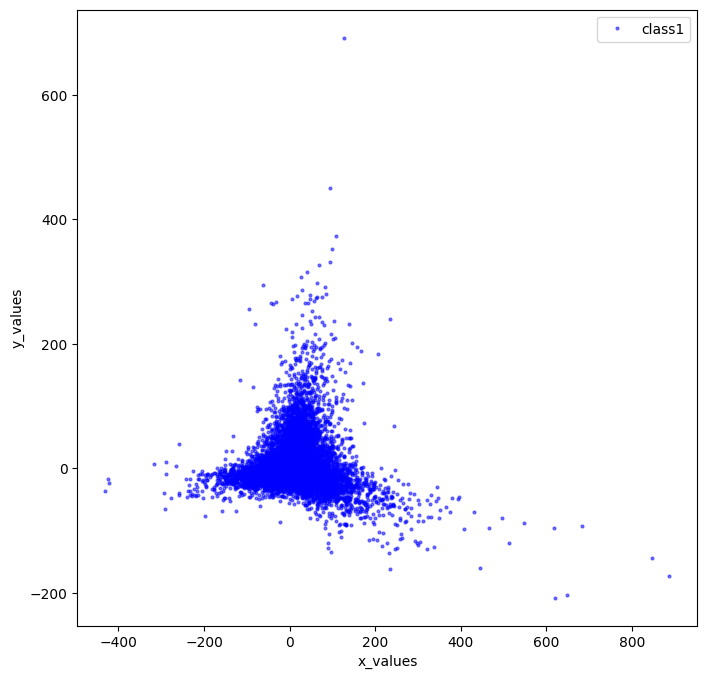

In [79]:
pc_val1, pc_val2 = 1, 4


tocluster = pd.DataFrame(ps[[pc_val1, pc_val2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[pc_val1], tocluster[pc_val2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

d:\5. DSA\5. DSA 10\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  0.10233217  -0.11845736]
 [ 65.33406503 -11.29429684]
 [-40.58312235  -4.70808001]
 [ 26.26358548  76.82338803]]


In [81]:
print (c_preds[0:100])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0]


Here is how our clusters appear

['orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


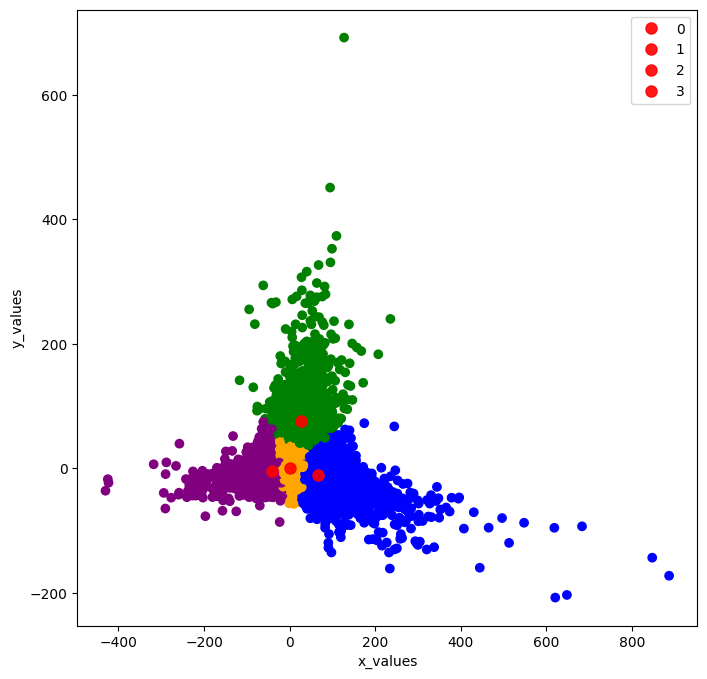

In [82]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[pc_val1],tocluster[pc_val2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

<text style="color:#00a18D">Pause: What happens when we try different Principal Components(features?)</text>

***

From the above, we have plotted several pair of components looking for the one suitable for a KMeans Clustering.  

I have chosen the (PC4,PC1) pair. Since each component is the projection of all the points of the original dataset I think each component is representative of the dataset. 

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [83]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,5,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,2,0,19,0


(206209, 135)


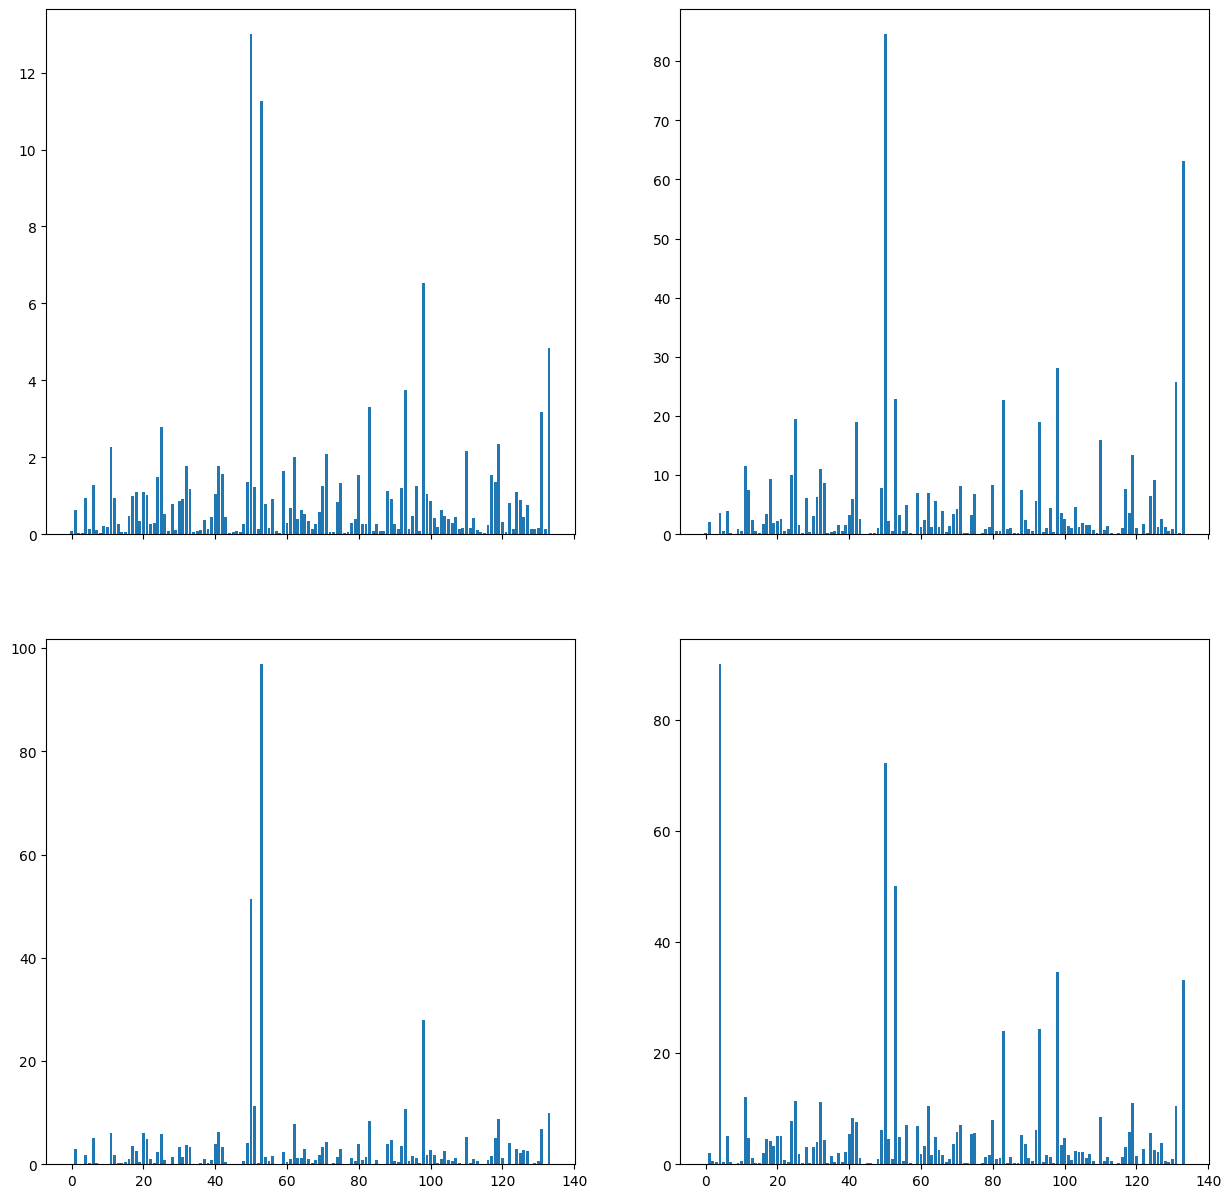

In [84]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()


Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [85]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     12.996203
fresh vegetables                 11.259972
packaged vegetables fruits        6.531537
yogurt                            4.840170
packaged cheese                   3.754606
milk                              3.303043
water seltzer sparkling water     3.169522
chips pretzels                    2.782864
soy lactosefree                   2.349798
bread                             2.279099
dtype: float64

In [88]:
c1.sort_values(ascending=False)[0:10].round(3)

aisle
fresh fruits                     84.542
yogurt                           63.035
packaged vegetables fruits       28.158
water seltzer sparkling water    25.796
fresh vegetables                 22.911
milk                             22.752
chips pretzels                   19.476
packaged cheese                  19.056
energy granola bars              19.044
refrigerated                     16.017
dtype: float64

In [89]:
c2.sort_values(ascending=False)[0:10].round(3)

aisle
fresh vegetables                 96.875
fresh fruits                     51.392
packaged vegetables fruits       27.903
fresh herbs                      11.310
packaged cheese                  10.643
yogurt                            9.924
soy lactosefree                   8.796
milk                              8.356
frozen produce                    7.808
water seltzer sparkling water     6.770
dtype: float64

In [93]:
c3.sort_values(ascending=False)[0:10].round(3)

aisle
baby food formula             90.031
fresh fruits                  72.334
fresh vegetables              50.059
packaged vegetables fruits    34.557
yogurt                        33.243
packaged cheese               24.305
milk                          23.997
bread                         12.201
chips pretzels                11.458
crackers                      11.248
dtype: float64

A first analysis of the clusters confirm the initial hypothesis that:

* fresh fruits                     
* fresh vegetables                 
* packaged vegetables fruits       
* yogurt                           
* packaged cheese                   
* milk                              
* water seltzer sparkling water     
* chips pretzels                    

are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters <text style="color:#b2f3f3">differ in quantities and proportions</text>, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [78]:
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
cluster_means.round(2)

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,50.18,75.87,26.55,69.43,16.63,17.42,9.27,8.99
1,12.41,12.70,6.25,4.64,3.39,3.03,2.37,2.27
2,32.09,34.08,21.97,12.48,15.40,11.66,25.49,16.93
3,103.25,42.84,31.74,14.09,12.74,15.37,7.82,8.33


The following table depicts the <text style="color:#f2b3b3">percentage these goods with respect to the other top 8 in each cluster</text>. It is easy some interesting differences among the clusters. 

It seems people of <text style="color:#f2b3b3">cluster 1 buy more fresh vegetables</text> than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of <text style="color:#c9e7cb">cluster 3 buy a Lot of 'Baby Food Formula'</text> which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [99]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: np.round((x / x.sum())*100, 3), axis=1)
cluster_perc

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,18.291,27.656,9.678,25.309,6.060,6.349,3.379,3.278
1,26.370,26.995,13.279,9.861,7.213,6.435,5.028,4.819
2,18.865,20.037,12.914,7.337,9.053,6.856,14.987,9.951
3,43.716,18.139,13.438,5.967,5.396,6.506,3.312,3.527


I think another interesting information my come by lookig at the 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [102]:
c0.sort_values(ascending=False)[10:15].round(3)

aisle
refrigerated      2.169
ice cream ice     2.083
frozen produce    2.002
eggs              1.778
crackers          1.766
dtype: float64

In [103]:
c1.sort_values(ascending=False)[10:15]

aisle
soy lactosefree    13.445793
bread              11.522340
crackers           11.004384
cereal              9.978081
candy chocolate     9.357781
dtype: float64

In [104]:
c2.sort_values(ascending=False)[10:15]

aisle
eggs                        6.175448
canned jarred vegetables    6.095968
bread                       6.019803
chips pretzels              5.795072
refrigerated                5.278674
dtype: float64

In [105]:
c3.sort_values(ascending=False)[10:15]

aisle
soy lactosefree                  11.003254
frozen produce                   10.577007
water seltzer sparkling water    10.527657
refrigerated                      8.530369
eggs                              8.318330
dtype: float64

As you can note by taking into account more products clusters start to differ significantly.

~ END